# Part 2: Regression

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [2]:
data = pd.read_pickle('data_new.pkl')

In [3]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    #'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    #'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    #'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [4]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [5]:
del data
#del X_train_lagpart
#del X_test_lagpart
#del X_valid_lagpart
gc.collect();
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8412924 entries, 2262708 to 10675631
Data columns (total 31 columns):
date_block_num                       int8
shop_id                              int8
item_id                              int16
city_code                            int8
item_category_id                     int8
type_code                            int8
subtype_code                         int8
item_cnt_month_lag_1                 float16
item_cnt_month_lag_2                 float16
item_cnt_month_lag_3                 float16
item_cnt_month_lag_6                 float16
date_avg_item_cnt_lag_1              float16
date_item_avg_item_cnt_lag_1         float16
date_item_avg_item_cnt_lag_2         float16
date_item_avg_item_cnt_lag_3         float16
date_item_avg_item_cnt_lag_6         float16
date_shop_avg_item_cnt_lag_1         float16
date_shop_avg_item_cnt_lag_2         float16
date_shop_avg_item_cnt_lag_3         float16
date_shop_avg_item_cnt_lag_6         float16


In [6]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse",     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.18636	validation_1-rmse:1.11894
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13928	validation_1-rmse:1.08197
[2]	validation_0-rmse:1.1002	validation_1-rmse:1.05277
[3]	validation_0-rmse:1.06591	validation_1-rmse:1.02671
[4]	validation_0-rmse:1.03654	validation_1-rmse:1.00617
[5]	validation_0-rmse:1.01156	validation_1-rmse:0.989469
[6]	validation_0-rmse:0.990985	validation_1-rmse:0.975477
[7]	validation_0-rmse:0.973188	validation_1-rmse:0.963227
[8]	validation_0-rmse:0.957764	validation_1-rmse:0.954722
[9]	validation_0-rmse:0.944243	validation_1-rmse:0.947554
[10]	validation_0-rmse:0.933859	validation_1-rmse:0.941637
[11]	validation_0-rmse:0.925372	validation_1-rmse:0.937056
[12]	validation_0-rmse:0.917243	validation_1-rmse:0.932606
[13]	validation_0-rmse:0.910197	validation_1-rmse:0.928466
[14]	validation_0-rmse:0.904512	valid

1292.9762001037598

In [7]:
test  = pd.read_csv('input/test.csv').set_index('ID')

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_new4.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle_new4', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle_new4', 'wb'))

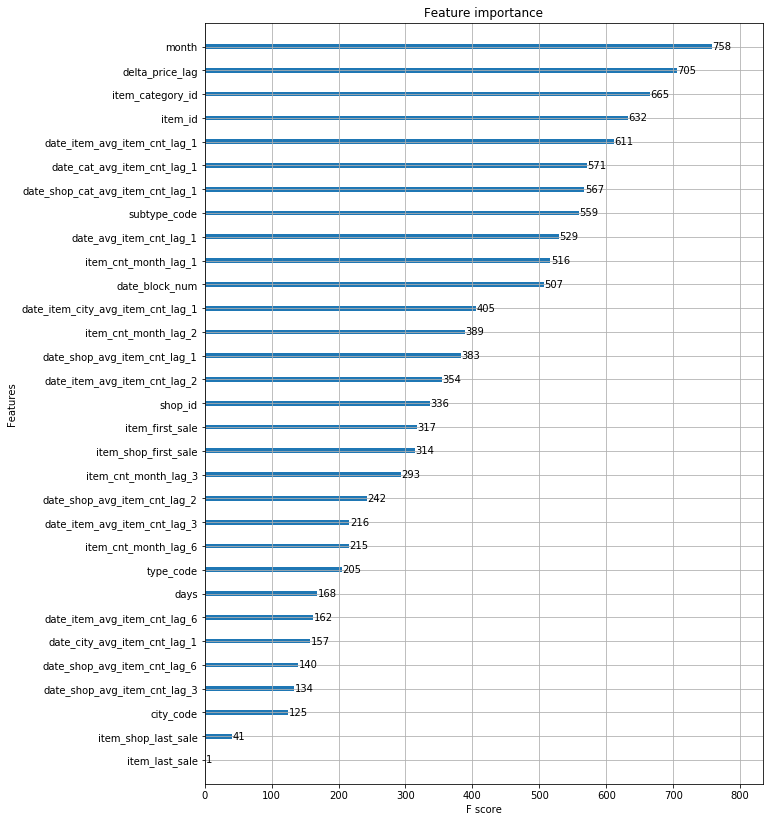

In [8]:
plot_features(model, (10,14))

In [9]:
del X_train
del Y_train
del X_valid
del Y_valid
del X_test
del Y_test
gc.collect()

19

 # End 